Encoding and Dataset:

In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [16]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Encode the target variable
label_encoder = LabelEncoder()
train_df['nforest_type_encoded'] = label_encoder.fit_transform(train_df['nforest_type'])

# Define features and target
X = train_df.drop(columns=['id', 'nforest_type', 'nforest_type_encoded'])
y = train_df['nforest_type_encoded']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally, use PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

# Split the transformed data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Convert Series to numpy array first
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)  # Convert Series to numpy array first

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Define and Train the Neural Network:

In [24]:
class ForestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ForestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Initialize the neural network, loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 256  # Increase the number of neurons
output_dim = len(label_encoder.classes_)
model = ForestNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# Train the neural network
num_epochs = 16
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {100 * correct / total:.2f}%')

Epoch 1/16, Train Loss: 0.8797, Val Loss: 0.7931, Val Accuracy: 65.61%
Epoch 2/16, Train Loss: 0.7967, Val Loss: 0.7789, Val Accuracy: 65.91%
Epoch 3/16, Train Loss: 0.7677, Val Loss: 0.7347, Val Accuracy: 67.83%
Epoch 4/16, Train Loss: 0.7483, Val Loss: 0.7236, Val Accuracy: 68.52%
Epoch 5/16, Train Loss: 0.7399, Val Loss: 0.7324, Val Accuracy: 67.02%
Epoch 6/16, Train Loss: 0.7325, Val Loss: 0.7062, Val Accuracy: 68.56%
Epoch 7/16, Train Loss: 0.7240, Val Loss: 0.7022, Val Accuracy: 69.63%
Epoch 8/16, Train Loss: 0.7189, Val Loss: 0.7052, Val Accuracy: 69.09%
Epoch 9/16, Train Loss: 0.7082, Val Loss: 0.6990, Val Accuracy: 69.02%
Epoch 10/16, Train Loss: 0.7034, Val Loss: 0.6939, Val Accuracy: 69.63%
Epoch 11/16, Train Loss: 0.6985, Val Loss: 0.7020, Val Accuracy: 69.05%
Epoch 12/16, Train Loss: 0.6943, Val Loss: 0.6895, Val Accuracy: 69.55%
Epoch 13/16, Train Loss: 0.6899, Val Loss: 0.6864, Val Accuracy: 69.67%
Epoch 14/16, Train Loss: 0.6831, Val Loss: 0.6804, Val Accuracy: 69.44%
E

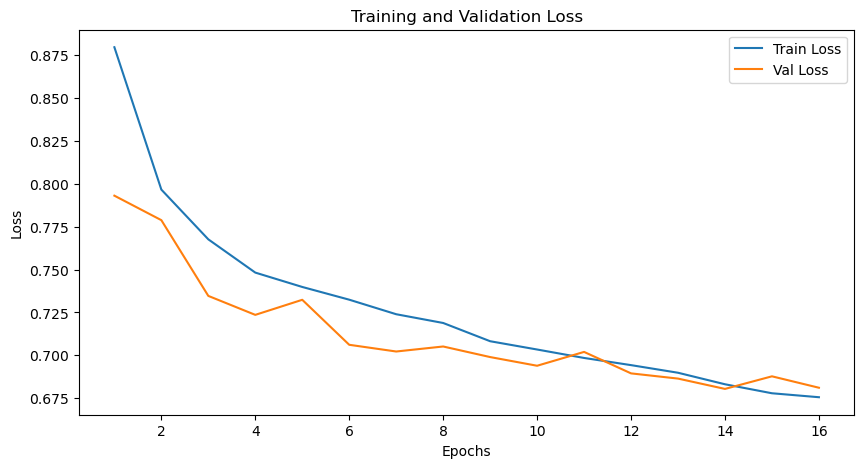

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
class NeuralNetworkWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, nn_model):
        self.nn_model = nn_model

    def fit(self, X, y):
        # Neural network is already trained
        pass

    def predict_proba(self, X):
        self.nn_model.eval()
        with torch.no_grad():
            outputs = self.nn_model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities.numpy()

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return probabilities.argmax(axis=1)


Train other ensemble model:

In [28]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Train LightGBM
lgb = LGBMClassifier(n_estimators=100, random_state=42)
lgb.fit(X_train, y_train)

# Train SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# Wrap the neural network
nn_wrapper = NeuralNetworkWrapper(model)

# Create an ensemble model
ensemble = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('lgb', lgb), ('svm', svm), ('nn', nn_wrapper)], voting='soft')

# Fit the ensemble
ensemble.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 10442, number of used features: 10
[LightGBM] [Info] Start training from score -1.044827
[LightGBM] [Info] Start training from score -1.615393
[LightGBM] [Info] Start training from score -0.799764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 10442, number of used features: 10
[LightGBM] [Info] Start training from score -1.044827
[LightGBM] [Info] Start training from score -1.615393
[LightGBM] [Info] Start training from score -0.799764


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_typ...
                                            objective='multi:softprob', ...)),
                             ('lgb', LGBMClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('nn',
                              NeuralNetworkWrapper(nn_model=ForestNN(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
  (relu): ReLU()
)))],
                 voting='soft')

Evaluate ensemble:

In [29]:
# Evaluate the ensemble on the validation set
val_predictions = ensemble.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy of the Ensemble: {val_accuracy:.4f}')

Validation Accuracy of the Ensemble: 0.7116


Make Prediction:

In [30]:
# Prepare the test data
test_X = test_df.drop(columns=['id'])
test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

# Make predictions with the ensemble
test_predictions = ensemble.predict(test_X_pca)
test_predictions_decoded = label_encoder.inverse_transform(test_predictions)

Inference:

In [31]:
# Load your sample submission file
sample_submission = pd.read_csv('sample_submission.csv')

# Merge the test data with sample submission to fill in the predicted values
predictions_df = pd.DataFrame({'id': test_df['id'], 'nforest_type': test_predictions_decoded})
final_submission = sample_submission.merge(predictions_df, on='id', how='left', suffixes=('', '_predicted'))

# Fill the missing values in sample submission with the predicted values
final_submission['nforest_type'] = final_submission['nforest_type'].combine_first(final_submission['nforest_type_predicted'])

# Drop the predicted column as it's no longer needed
final_submission = final_submission.drop(columns=['nforest_type_predicted'])

# Save the final submission
final_submission.to_csv('submitfile/EnsembleNN.csv', index=False)